In [1]:
import jax
import jax.numpy as jnp
import optax
import treescope
from IPython.display import display as ipython_display
from penzai.core.named_axes import NamedArray
from penzai.models.transformer.model_parts import TransformerLM

from simplexity.generative_processes.hidden_markov_model import HiddenMarkovModel
from simplexity.generative_processes.state_sampler import StateSampler
from simplexity.load_objects import load_config, load_objects


In [2]:
treescope.basic_interactive_setup(autovisualize_arrays=True)

In [3]:
from typing import Any

from penzai import pz


@pz.pytree_dataclass
class SaveActivations(pz.nn.Layer):
    """Layer to save activations."""

    saved_activations: pz.StateVariable[list[Any]]

    def __call__(self, activations: Any, **unused_side_inputs) -> Any:
        """Save activations as a side effect."""
        self.saved_activations.value = self.saved_activations.value + [activations]
        return activations

In [4]:
from simplexity.persistence.s3_persister import S3Persister
from simplexity.predictive_models.types import ModelFramework

persister = S3Persister.from_config("/workspaces/simplexity/config.ini", ModelFramework.Penzai)

cfg = load_config("/workspaces/simplexity/simplexity/configs", "load.yaml")
d = load_objects(cfg)

generative_process: HiddenMarkovModel = d["generative_process"]
state_sampler: StateSampler = d["state_sampler"]
unbound_model: TransformerLM = d["model"]

activations = pz.StateVariable(value=[], label="activations")
saving_model = (pz.select(unbound_model).at_instances_of(pz.nn.Residual).insert_after(SaveActivations(activations)))
ipython_display(saving_model)

TransformerLM(
  body=Sequential(
    sublayers=[
      EmbeddingLookup(table=EmbeddingTable(embeddings=Parameter(label='transformer/embedder.embeddings', value=<NamedArray float32(| vocabulary:2, embedding:16) ≈0.016 ±0.2 [≥-0.4, ≤0.37] nonzero:32 (wrapping jax.Array)>, metadata={}), vocabulary_axis='vocabulary')),
      TransformerBlock(sublayers=[Residual(delta=Sequential(sublayers=[RMSLayerNorm(sublayers=[RMSStandardize(across=('embedding',), epsilon=<jax.Array(1.e-06, dtype=float32)>), Linear(weights=Parameter(label='transformer/block_0/pre_attention_norm/scale.weights', value=<NamedArray float32(| embedding:16) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:16 (wrapping jax.Array)>, metadata={}), in_axis_names=(), out_axis_names=())]), Attention(input_to_query=Sequential(sublayers=[Linear(weights=Parameter(label='transformer/block_0/attention/query.weights', value=<NamedArray float32(| embedding:16, head_groups:2, query_heads:2, projection:16) ≈0.00037 ±0.16 [≥-0.27, ≤0.27] nonzero:1_024 (wrapping jax.Array)>, metadata={}), in_axis_names=('embedding',), out_axis_names=('head_groups', 'query_heads', 'projection')), ApplyRoPE(embedding_axis='projection', max_wavelength=10000, positions_input_name='token_positions'), ConstantRescale(by=<jax.Array(0.25, dtype=float32)>)]), input_to_key=Sequential(sublayers=[Linear(weights=Parameter(label='transformer/block_0/attention/key.weights', value=<NamedArray float32(| embedding:16, head_groups:2, projection:16) ≈0.00019 ±0.2 [≥-0.35, ≤0.35] nonzero:512 (wrapping jax.Array)>, metadata={}), in_axis_names=('embedding',), out_axis_names=('head_groups', 'projection')), ApplyRoPE(embedding_axis='projection', max_wavelength=10000, positions_input_name='token_positions')]), input_to_value=Sequential(sublayers=[Linear(weights=Parameter(label='transformer/block_0/attention/value.weights', value=<NamedArray float32(| embedding:16, head_groups:2, projection:16) ≈0.013 ±0.2 [≥-0.35, ≤0.35] nonzero:512 (wrapping jax.Array)>, metadata={}), in_axis_names=('embedding',), out_axis_names=('head_groups', 'projection'))]), query_key_to_attn=Sequential(sublayers=[NamedEinsum(input_axes=({'seq': 'tq', 'head_groups': 'hg', 'query_heads': 'hq', 'projection': 'p'}, {'seq': 'tkv', 'head_groups': 'hg', 'projection': 'p'}), output_axes={'seq': 'tq', 'head_groups': 'hg', 'query_heads': 'hq', 'kv_seq': 'tkv'}), ApplyCausalAttentionMask(masked_out_value=<jax.Array(-2.3819763e+38, dtype=float32)>, query_positions_input_name='token_positions', kv_positions_input_name='token_positions', seq_axis='seq', kv_seq_axis='kv_seq'), Softmax(axes='kv_seq')]), attn_value_to_output=Sequential(sublayers=[NamedEinsum(input_axes=({'seq': 'tq', 'head_groups': 'hg', 'query_heads': 'hq', 'kv_seq': 'tkv'}, {'seq': 'tkv', 'head_groups': 'hg', 'projection': 'p'}), output_axes={'seq': 'tq', 'head_groups': 'hg', 'query_heads': 'hq', 'projection': 'p'}), Linear(weights=Parameter(label='transformer/block_0/attention/output.weights', value=<NamedArray float32(| head_groups:2, query_heads:2, projection:16, embedding:16) ≈0.0022 ±0.16 [≥-0.27, ≤0.27] nonzero:1_024 (wrapping jax.Array)>, metadata={}), in_axis_names=('head_groups', 'query_heads', 'projection'), out_axis_names=('embedding',))]))])), SaveActivations(saved_activations=StateVariable(label='activations', value=[], metadata={})), Residual(delta=Sequential(sublayers=[RMSLayerNorm(sublayers=[RMSStandardize(across=('embedding',), epsilon=<jax.Array(1.e-06, dtype=float32)>), Linear(weights=Parameter(label='transformer/block_0/pre_ffw_norm/scale.weights', value=<NamedArray float32(| embedding:16) ≈1.0 ±0.0 [≥1.0, ≤1.0] nonzero:16 (wrapping jax.Array)>, metadata={}), in_axis_names=(), out_axis_names=())]), TransformerFeedForward(sublayers=[BranchAndMultiplyTogether(branches=[NamedGroup(name='gate', sublayers=[Linear(weights=Parameter(label='transformer/block_0/mlp/gating_linear.weights', value=<NamedArray float32(| embedding:16, neurons:16) ≈0.011 ±0.24 [≥-0.43, ≤0.43] nonzero:256 (wrapping jax.Array)>, met

In [5]:
import equinox as eqx

from simplexity.training.train_penzai_model import generate_data_batch

sample_states = eqx.filter_jit(eqx.filter_vmap(state_sampler.sample))

batch_size = 2048
sequence_len = 100

key = jax.random.PRNGKey(0)
state_key, key = jax.random.split(key)
state_keys = jax.random.split(state_key, batch_size)

states = sample_states(state_keys)

_, inputs, labels = generate_data_batch(
    states,
    generative_process,
    batch_size=batch_size,
    sequence_len=sequence_len,
    key=key,
    bos_token=5,
)

name = jnp.logical_or(inputs == 3, inputs == 4)
named_name = pz.nx.wrap(name, "batch", "seq")
ipython_display(named_name)


<NamedArray bool(| batch:2048, seq:100) true:33_867 false:170_933 (wrapping jax.Array)
  <Arrayviz rendering>
| Device: GPU 0>

In [6]:
results = {}

In [79]:
step = 1000
model: TransformerLM = persister.load_weights(unbound_model, step)  # type: ignore

named_inputs = pz.nx.wrap(inputs, "batch", "seq")
named_logits = model(named_inputs)
assert isinstance(named_logits, NamedArray)
logits = named_logits.unwrap("batch", "seq", "vocabulary")
losses = optax.softmax_cross_entropy_with_integer_labels(logits, labels)
named_losses = pz.nx.wrap(losses, "batch", "seq")

# ipython_display(named_losses)

/workspaces/simplexity/.venv/lib/python3.13/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1250: UserWarning: Couldn't find sharding info under RestoreArgs. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file instead of directly from RestoreArgs. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [80]:
name_losses = [[] for _ in range(batch_size)]
for b in range(batch_size):
    for s in range(sequence_len - 1):
        if name[b, s]:
            if s > 0:
                loss = losses[b, s - 1].item()  # type: ignore
            else:
                loss = -1
            # if loss > 0.01:
            #     print(b, s, name[b, s].item(), losses[b, s-1].item())  # type: ignore
            name_losses[b].append(loss)

# ipython_display(name_losses)

max_len = max(map(len, name_losses))

name_pos_posses = [[] for _ in range(max_len)]
for seq in name_losses:
    for i, loss in enumerate(seq):
        name_pos_posses[i].append(loss)
name_pos_posses[0] = [v for v in name_pos_posses[0] if v != -1]

# ipython_display(name_pos_posses)

mean_losses = jnp.array([jnp.mean(jnp.array(v)) for v in name_pos_posses])
ipython_display(mean_losses)


<jax.Array float32(24,) ≈0.046 ±0.21 [≥0.0016, ≤1.1] nonzero:24
  <Arrayviz rendering>
| Device: GPU 0>

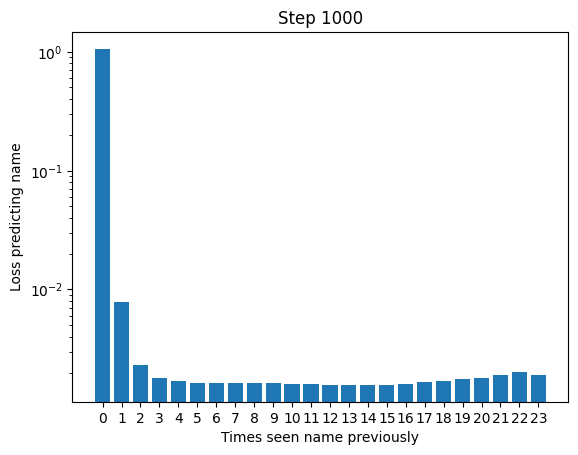

In [81]:
import matplotlib.pyplot as plt

plt.bar(range(len(mean_losses)), mean_losses)
plt.yscale("log")
plt.xticks(range(len(mean_losses)), list(map(str, range(len(mean_losses)))))
plt.xlabel("Times seen name previously")
plt.ylabel("Loss predicting name")
plt.title(f"Step {step}")
plt.show()


In [82]:
results[step] = mean_losses
results

{10: <jax.Array float32(24,) ≈2.0 ±0.19 [≥1.5, ≤2.4] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 20: <jax.Array float32(24,) ≈1.7 ±0.2 [≥1.1, ≤2.3] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 30: <jax.Array float32(24,) ≈1.2 ±0.23 [≥0.91, ≤2.2] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 40: <jax.Array float32(24,) ≈0.66 ±0.32 [≥0.44, ≤2.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 50: <jax.Array float32(24,) ≈0.42 ±0.37 [≥0.26, ≤2.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 60: <jax.Array float32(24,) ≈0.29 ±0.43 [≥0.17, ≤2.3] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 70: <jax.Array float32(24,) ≈0.23 ±0.43 [≥0.11, ≤2.3] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 80: <jax.Array float32(24,) ≈0.19 ±0.4 [≥0.085, ≤2.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 90: <jax.Array float32(24,) ≈0.16 ±0.37 [≥0.064, ≤1.9] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 100: <jax.Array float32(24,) ≈0.14 ±0.34 [≥0.05, ≤1.8] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 200: <jax.Array float32(24,) ≈0.067 ±0.23 [≥0.015, ≤1.2] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 300: <jax.Array float32(24,) ≈0.055 ±0.22 [≥0.0085, ≤1.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 400: <jax.Array float32(24,) ≈0.05 ±0.21 [≥0.0057, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 500: <jax.Array float32(24,) ≈0.048 ±0.2 [≥0.0042, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 600: <jax.Array float32(24,) ≈0.048 ±0.21 [≥0.0033, ≤1.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 700: <jax.Array float32(24,) ≈0.046 ±0.2 [≥0.0026, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 800: <jax.Array float32(24,) ≈0.046 ±0.21 [≥0.0022, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 900: <jax.Array float32(24,) ≈0.044 ±0.2 [≥0.0018, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 1000: <jax.Array float32(24,) ≈0.046 ±0.21 [≥0.0016, ≤1.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>}

In [91]:
new_results = {str(k * 100 * 512): v for k, v in results.items()}
new_results


{'512000': <jax.Array float32(24,) ≈2.0 ±0.19 [≥1.5, ≤2.4] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '1024000': <jax.Array float32(24,) ≈1.7 ±0.2 [≥1.1, ≤2.3] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '1536000': <jax.Array float32(24,) ≈1.2 ±0.23 [≥0.91, ≤2.2] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '2048000': <jax.Array float32(24,) ≈0.66 ±0.32 [≥0.44, ≤2.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '2560000': <jax.Array float32(24,) ≈0.42 ±0.37 [≥0.26, ≤2.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '3072000': <jax.Array float32(24,) ≈0.29 ±0.43 [≥0.17, ≤2.3] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '3584000': <jax.Array float32(24,) ≈0.23 ±0.43 [≥0.11, ≤2.3] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '4096000': <jax.Array float32(24,) ≈0.19 ±0.4 [≥0.085, ≤2.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '4608000': <jax.Array float32(24,) ≈0.16 ±0.37 [≥0.064, ≤1.9] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '5120000': <jax.Array float32(24,) ≈0.14 ±0.34 [≥0.05, ≤1.8] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '10240000': <jax.Array float32(24,) ≈0.067 ±0.23 [≥0.015, ≤1.2] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '15360000': <jax.Array float32(24,) ≈0.055 ±0.22 [≥0.0085, ≤1.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '20480000': <jax.Array float32(24,) ≈0.05 ±0.21 [≥0.0057, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '25600000': <jax.Array float32(24,) ≈0.048 ±0.2 [≥0.0042, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '30720000': <jax.Array float32(24,) ≈0.048 ±0.21 [≥0.0033, ≤1.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '35840000': <jax.Array float32(24,) ≈0.046 ±0.2 [≥0.0026, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '40960000': <jax.Array float32(24,) ≈0.046 ±0.21 [≥0.0022, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '46080000': <jax.Array float32(24,) ≈0.044 ±0.2 [≥0.0018, ≤1.0] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>,
 '51200000': <jax.Array float32(24,) ≈0.046 ±0.21 [≥0.0016, ≤1.1] nonzero:24
   <Arrayviz rendering>
 | Device: GPU 0>}

In [92]:
jnp.savez("name_losses.npz", **new_results, allow_pickle=True)